# Detecção de Alvos lineares em imagens de Sonar

## Imports

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import label2rgb

## Constants

In [2]:
IMAGE_PATH = "images/204145.png"
# IMAGE_PATH = "images/204146.png"

## Load Image

In [3]:
raw_image = cv.imread(IMAGE_PATH)[:, :, 0]

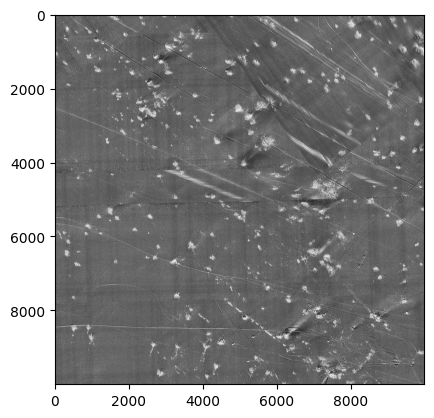

In [4]:
plt.imshow(raw_image, cmap = "gray")

In [5]:
raw_image.shape

(10000, 10000)

## Histogram Equalization

In [6]:
clahe = cv.createCLAHE(clipLimit = 10, tileGridSize = (3,3))
cl1 = clahe.apply(raw_image)

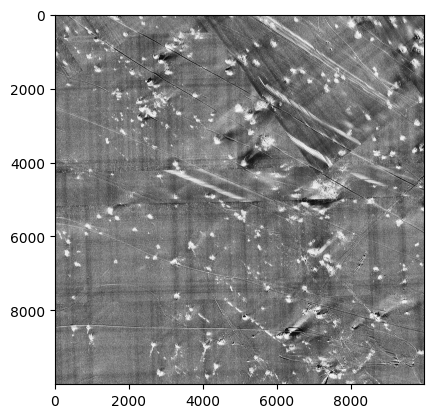

In [7]:
plt.imshow(cl1, cmap = "gray")

## Detect Horizontal Lines with Morphology

In [8]:
horizontal_size = cl1.shape[1] // 800

In [9]:
horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))

In [10]:
horizontal_structure

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [11]:
horizontal = cv.erode(cl1, horizontal_structure)
horizontal = cv.dilate(cl1, horizontal_structure)

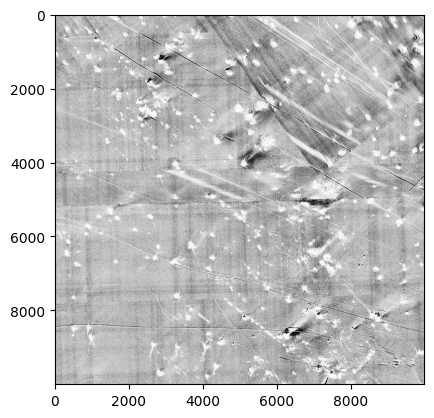

In [12]:
plt.imshow(horizontal, cmap = "gray")

In [13]:
horizontal_threshold = np.where(horizontal >= 225, 1, 0).astype(np.uint8)

In [14]:
horizontal_threshold.shape

(10000, 10000)

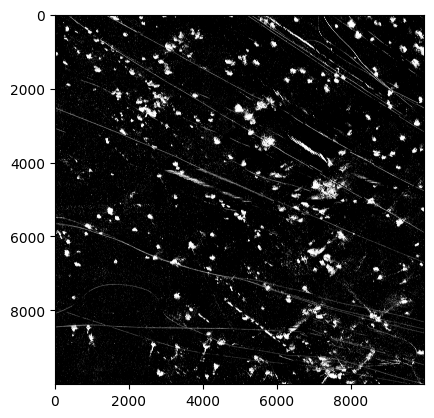

In [15]:
plt.imshow(horizontal_threshold, cmap = "binary_r")

## Detect Vertical Lines with Morphology

In [16]:
vertical_size = cl1.shape[0] // 500

In [17]:
vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))

In [18]:
vertical_structure

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [19]:
vertical = cv.erode(cl1, vertical_structure)
vertical = cv.dilate(cl1, vertical_structure)

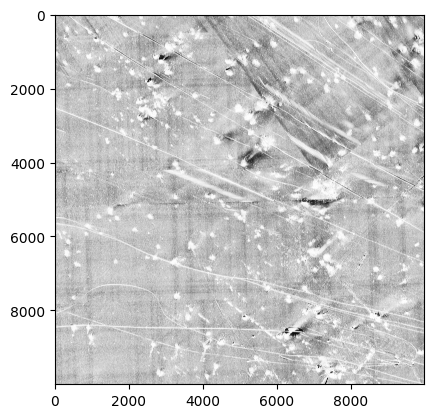

In [20]:
plt.imshow(vertical, cmap = "gray")

In [21]:
vertical_threshold = np.where(vertical >= 225, 1, 0).astype(np.uint8)

In [22]:
vertical_threshold.shape

(10000, 10000)

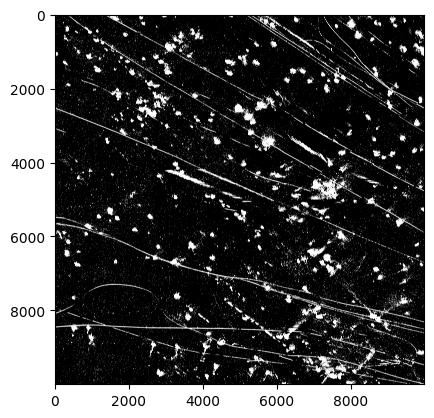

In [23]:
plt.imshow(vertical_threshold, cmap = "binary_r")

## Union Detect Lines

In [24]:
lines_threshold = cv.bitwise_or(horizontal_threshold, vertical_threshold)

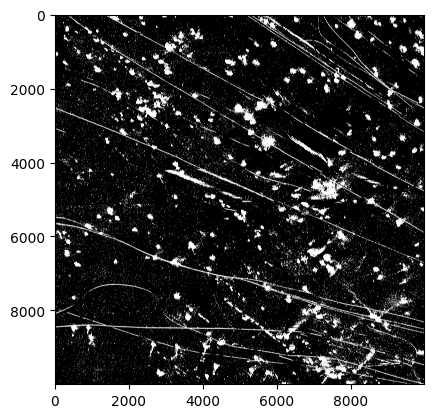

In [25]:
plt.imshow(lines_threshold, cmap = "binary_r")

## TO-DO
1. Testar equalização de histograma local com scikit-image
2. Após a transformada de hough, aplicar análise de componentes conexas
3. Manter somente objetos que tem maior length

In [26]:
# Análise de componentes conexas
label_image = label(lines_threshold)

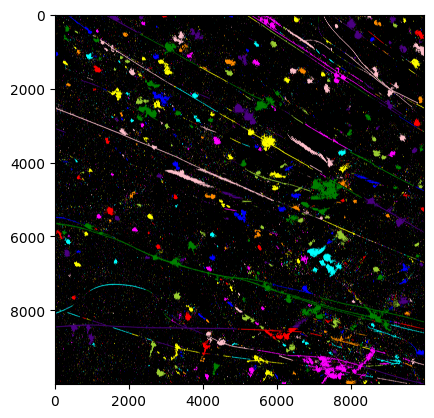

In [27]:
plt.imshow( label2rgb(label_image, bg_label=0) )

## Detect only lines

### Case 1 - Detectar somente linhas lineares a partir de eccentricidade, eixo maior e eixo menor

In [28]:
# # Filtrar linhas baseadas em propriedades geométricas
# # Ajuste os valores de limiar conforme necessário
# min_eccentricity = 0.90  # Linhas tendem a ter alta excentricidade
# min_major_axis_length = 50  # Ajuste baseado no tamanho esperado das linhas
# max_minor_axis_length = 300  # Linhas devem ser estreitas\\\\

# # Propriedades dos componentes conectados
# properties = regionprops(label_image)

# for prop in properties:
#     if (prop.eccentricity > min_eccentricity and 
#         prop.major_axis_length > min_major_axis_length and 
#         prop.minor_axis_length < max_minor_axis_length
#        ):
#         # Marcar o componente como linha
#         lines_mask[label_image == prop.label] = 1

In [29]:
# # Mostrar a imagem original e a imagem com as linhas identificadas
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(lines_threshold, cmap='gray')
# ax[0].set_title('Imagem Binária')
# ax[0].axis('off')

# ax[1].imshow(lines_mask, cmap='gray')
# ax[1].set_title('Linhas Identificadas')
# ax[1].axis('off')

# plt.show()

### Case 2 - Detectar objetos lineares e arredondados a partir de elongation e roundness

In [30]:
# Propriedades dos componentes conectados
properties = regionprops(label_image)

In [31]:
# Parâmetros ajustáveis
MIN_WIDTH = 250 # Largura minima
ROUNDNESS_THRESHOLD = 0.05  # Limite de arredondamento para objetos arredondados
LINEAR_ASPECT_RATIO_THRESHOLD = 1.02  # Limite de razão de aspecto para objetos lineares
EXTENSION_THRESHOLD = 3.0  # Limite de extensão para objetos lineares
AREA_WIDTH_HEIGHT_THRESHOLD = 0.25 # Limite da area em relação a altura e largura do objeto

In [32]:
lines_mask = np.zeros_like(raw_image)

#### Elongation e Roundness com Análise de componenetes conexas (Scikit-Imagem)

In [33]:
# Processar cada região
for region in properties:
    # Calcular a bounding box e as características geométricas
    minr, minc, maxr, maxc = region.bbox
    width = maxc - minc
    height = maxr - minr

    if width < MIN_WIDTH:
        continue

    # Calcular a razão de aspecto (invariante à orientação)
    if height > 0:
        aspect_ratio = width / height
    else:
        aspect_ratio = 0

    # Calcular a arredondamento
    if region.perimeter > 0:
        roundness = (4 * np.pi * region.area) / (region.perimeter ** 2)
    else:
        roundness = 0

    # Calcular a extensão (elongation)
    if region.perimeter > 0:
        extension = region.area / region.perimeter
    else:
        extension = 0

    # Area em relação a altura e largura do objeto
    area_width_height = region.area / (width * height)

    # Definir limiares para classificar objetos arredondados e lineares
    if \
        (aspect_ratio >= LINEAR_ASPECT_RATIO_THRESHOLD) and \
        (extension >= EXTENSION_THRESHOLD) and \
        (roundness < ROUNDNESS_THRESHOLD) and \
        (area_width_height < AREA_WIDTH_HEIGHT_THRESHOLD):
        # Objeto linear
        lines_mask[label_image == region.label] = 1
    else:
        # Outro objeto
        lines_mask[label_image == region.label] = 2

In [34]:
lines_mask_rgb = label2rgb(lines_mask, colors = [(255, 0, 0), (255, 255, 255)]).astype(np.uint8)

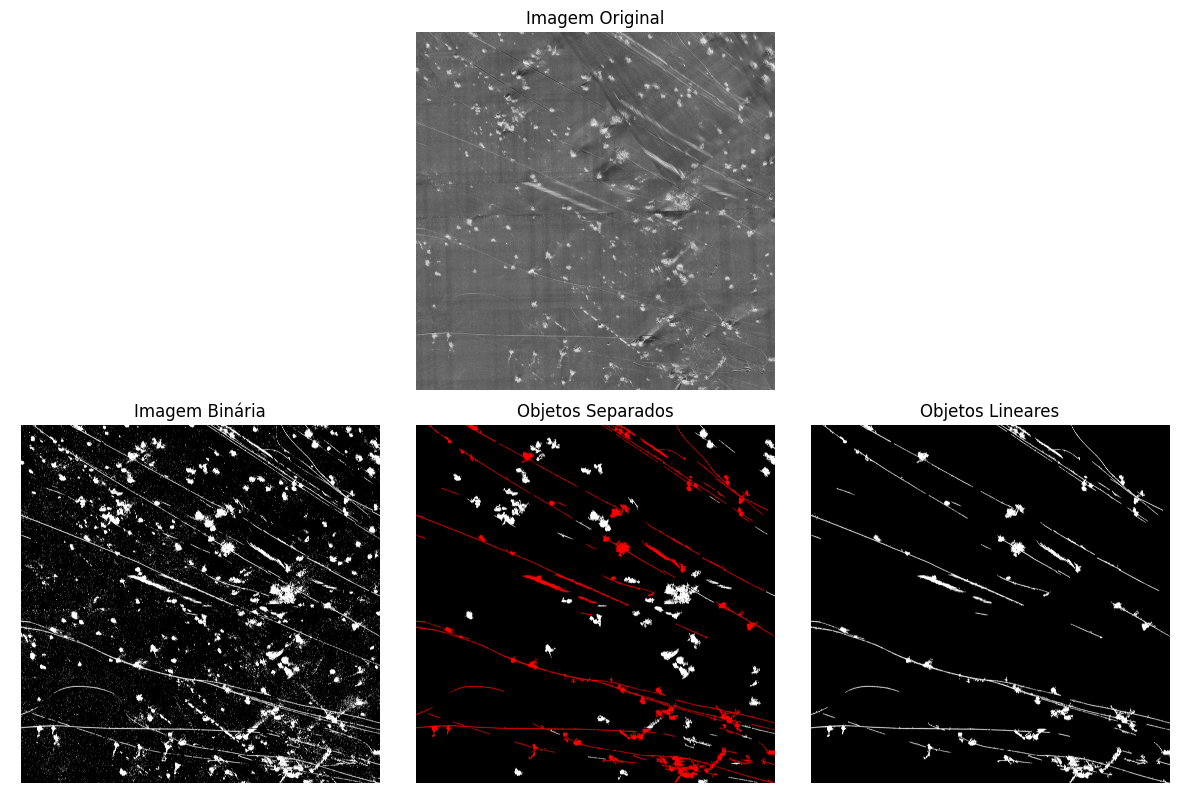

In [35]:
# Mostrar a imagem original, imagem binária, objetos separados e objetos lineares
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][1].imshow(raw_image, cmap='gray')
ax[0][1].set_title('Imagem Original')
ax[0][1].axis('off')
ax[0][0].axis('off')
ax[0][2].axis('off')

ax[1][0].imshow(lines_threshold, cmap='gray')
ax[1][0].set_title('Imagem Binária')
ax[1][0].axis('off')

ax[1][1].imshow(lines_mask_rgb)
ax[1][1].set_title('Objetos Separados')
ax[1][1].axis('off')

ax[1][2].imshow(np.where(lines_mask == 1, 255, 0), cmap = "gray")
ax[1][2].set_title('Objetos Lineares')
ax[1][2].axis('off')

plt.tight_layout()
plt.show()

In [36]:
contours, _ = cv.findContours(lines_threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Criar uma imagem para visualizar os objetos classificados
output_image = cv.cvtColor(lines_threshold, cv.COLOR_GRAY2BGR)

# Processar cada contorno
for contour in contours:
    # Calcular o perímetro e a área do contorno
    perimeter = cv.arcLength(contour, True)
    area = cv.contourArea(contour)
    
    # Ignorar contornos muito pequenos para evitar ruídos
    if area < MIN_AREA:
        continue
    
    # Calcular a bounding box e a razão de aspecto (alongamento)
    x, y, w, h = cv.boundingRect(contour)
    aspect_ratio = max(w, h) / min(w, h)

    # Calcular a arredondamento
    roundness = (4 * np.pi * area) / (perimeter ** 2)
    
    # Calcular o centro de massa do contorno para posicionar a etiqueta
    M = cv.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = x + w // 2, y + h // 2

    # Definir limiares para classificar objetos arredondados e lineares
    if roundness > ROUNDNESS_THRESHOLD and aspect_ratio < ASPECT_RATIO_THRESHOLD:  # Ajustar esses valores conforme necessário
        # Objeto arredondado (classe 2)
        cv.fillPoly(output_image, [contour], (255, 0, 0))
    elif aspect_ratio >= LINEAR_ASPECT_RATIO_THRESHOLD:
        # Objeto linear (classe 1)
        cv.fillPoly(output_image, [contour], (0, 255, 0))

NameError: name 'MIN_AREA' is not defined

In [ ]:
# Mostrar a imagem original e a imagem com as linhas identificadas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(lines_threshold, cmap='gray')
ax[0].set_title('Imagem Binária')
ax[0].axis('off')

ax[1].imshow(output_image)
ax[1].set_title('Objetos Separados')
ax[1].axis('off')

plt.show()